In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#from textblob import TextBlob as tb
from autocorrect import Speller as sp
import emoji
import nltk
from nltk.tokenize import word_tokenize as wt,sent_tokenize as st
from nltk.corpus import stopwords
from nltk import PorterStemmer,LancasterStemmer,SnowballStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.pipeline import Pipeline ,make_pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import FunctionTransformer,PowerTransformer,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,r2_score
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manikanta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manikanta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Manikanta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1.Problem Statement
Create a model for predicting sentiment analysis on flipkart whether the review is positive or not?

### 2. Data Collection

In [2]:
data = pd.read_csv(r"C:\Users\Manikanta\Data Science Innomatics\Internship Projects - Tasks\Sentiment Analysis mlflow\reviews_data_dump\reviews_badminton\data.csv")

df = data.copy()

df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


### 3.EDA before Text pre-processing

In [3]:
df.shape   # data contains 8518 rows and 8 columns

(8518, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [5]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [6]:
## data contains both numerical and categorical data types

In [7]:
# Based on my problem statement i don't need theese columns so simply drop those columns

df.drop(columns = ['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes','Down Votes', 'Month'],inplace = True)

In [8]:
df.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [9]:
df.isnull().sum()

Review text    8
Ratings        0
dtype: int64

In [10]:
df.dropna(inplace = True)

In [11]:
df.isnull().sum()

Review text    0
Ratings        0
dtype: int64

In [12]:
df.duplicated().sum()

3269

In [13]:
df.drop_duplicates(inplace = True)

In [14]:
df.Ratings.value_counts()

5    2882
4     967
1     670
3     443
2     279
Name: Ratings, dtype: int64

In [15]:
df.Ratings = df.Ratings.apply(lambda x : "Positive" if x>=4 else "Negative")

df.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,Negative
2,Worst product. Damaged shuttlecocks packed in ...,Negative
3,"Quite O. K. , but nowadays the quality of the...",Negative
4,Over pricedJust â?¹620 ..from retailer.I didn'...,Negative


In [16]:
df.Ratings.value_counts()

Positive    3849
Negative    1392
Name: Ratings, dtype: int64

In [17]:
fv = df.iloc[:,0:1]

cv = df.iloc[:,-1]

In [18]:
fv.columns = ["Reviews"]

In [19]:
fv.head()

,Reviews
0,"Nice product, good quality, but price is now r..."
1,They didn't supplied Yonex Mavis 350. Outside ...
2,Worst product. Damaged shuttlecocks packed in ...
3,"Quite O. K. , but nowadays the quality of the..."
4,Over pricedJust â?¹620 ..from retailer.I didn'...


In [20]:
cv = cv.map({"Positive":1,"Negative":0})

cv.head()

0    1
1    0
2    0
3    0
4    0
Name: Ratings, dtype: int64

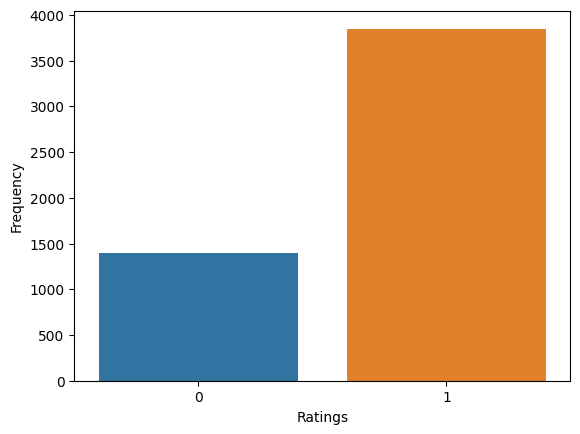

In [21]:
sns.barplot(x = cv.value_counts().index , y = cv.value_counts().values)
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()

In [22]:
x_train,x_test,y_train,y_test = train_test_split(fv,cv,stratify=cv,random_state=1,test_size=0.2)

In [23]:
print("size of Xtrain is: ", x_train.shape)

print("size of x_test is :", x_test.shape)

size of Xtrain is:  (4192, 1)
size of x_test is : (1049, 1)


In [24]:
def checkText(data,col_name):
    case    = " ".join(data[col_name]).islower()
    html    = data[col_name].apply(lambda x:True if re.search("<.+?>",x) else False).sum()
    url     = data[col_name].apply(lambda x:True if re.search("https[s]?://.+? +",x) else False).sum()
    special = data[col_name].apply(lambda x:True if re.search("[]()*\-.:,@#$%&^!?/0-9']",x) else False).sum()
    count = 0

    for sen in data[col_name]:
        for char in sen.split():
            if emoji.is_emoji(char):
                count += 1
    if count>0:
        print("text have emojies")
    else:
        print("text does't have emojies")

    if special > 0:
        print("text have special characters")
    else:
        print("text does't have special characters")

    if url > 0:
        print("text have urls")
    else:
        print("text does't have urls")

    if html > 0:
        print("text have html tags")
    else:
        print("text does't have html tags")

    if case == False:
        print("text not in lower case")
    else:
        print("text in lower case")

checkText(x_train,"Reviews")

text have emojies
text have special characters
text does't have urls
text does't have html tags
text not in lower case


### 4.Text pre-processing

In [25]:
def lowers(x):
    return x.str.lower()

def html(x):
    return x.apply(lambda x:re.sub("<.+?>"," ",x))

def url(x):
    return x.apply(lambda x:re.sub("https[s]?://.+? +"," ",x))

def unw(x):
    return x.apply(lambda x:re.sub("[]()*\-.:,@#$%&^!?/0-9']"," ",x))

def unw_1(x):
    return x.apply(lambda x:re.sub(r'[^\w\s]','',x))

def emoji_remove(x):
    x = x.apply(lambda x : emoji.demojize(x))
    return x


def lemma(x):
  list_stp = stopwords.words("english")  # list_stp contains group of stop words.
  wl=WordNetLemmatizer()

  def lemmatize_text(text):
        words = wt(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]
        return " ".join(lemmatized_words)

  return x.apply(lemmatize_text)

# create a pipeline for pre-processing the data
pre_pro_pi = Pipeline([("emojii remover",FunctionTransformer(emoji_remove)),
                       ("lower",FunctionTransformer(lowers)),
                       ("html",FunctionTransformer(html)),
                       ("url",FunctionTransformer(url)),
                       ("unw",FunctionTransformer(unw)),
                       ("unw2",FunctionTransformer(unw_1)),
                       ("advance",FunctionTransformer(lemma))])

In [26]:
clean_data = pre_pro_pi.fit_transform(x_train['Reviews'])

clean_data = pd.DataFrame(clean_data)

checkText(clean_data,"Reviews")

text does't have emojies
text does't have special characters
text does't have urls
text does't have html tags
text not in lower case


### 5. EDA after Pre-processing

In [27]:
data_eda = pd.concat([clean_data,y_train],axis=1)

data_eda

,Reviews,Ratings
7998,nice quality come timeread,1
4765,time quality good please care brotherread,0
3350,buy flipkart totally buy priceread,1
409,valuable product thumbs_up read,1
8049,great stuff read,0
...,...,...
5998,yonex always provide good quality read,1
3061,superb product receive expect time read,1
171,bad quality good dont like prefer beacuse deli...,0
139,local productread,0


In [28]:
gp = data_eda.groupby("Ratings")
neg_rows = gp.get_group(0)["Reviews"]
posi_rows = gp.get_group(1)["Reviews"]

In [29]:
# Combine entire rows text into one text
pos = " ".join(posi_rows).split()
nega = " ".join(neg_rows).split()

In [30]:
print("positive class contains",len(pos),"number of words")
print("negative class contains",len(nega),"number of words")

positive class contains 14974 number of words
negative class contains 6981 number of words


In [31]:
#pip install wordcloud

In [32]:
from collections import Counter
Counter(pos).most_common(10)

[('read', 1079),
 ('good', 1057),
 ('product', 723),
 ('shuttle', 471),
 ('nice', 404),
 ('quality', 366),
 ('best', 306),
 ('productread', 215),
 ('original', 205),
 ('delivery', 200)]

In [33]:
Counter(nega).most_common(10)

[('read', 393),
 ('shuttle', 351),
 ('quality', 290),
 ('product', 242),
 ('good', 195),
 ('bad', 160),
 ('thumbs_down', 134),
 ('one', 96),
 ('get', 87),
 ('buy', 83)]

In [34]:
#from wordcloud import WordCloud

#wc = WordCloud().generate(" ".join(pos))
#plt.imshow(wc)
#plt.axis("off")
#plt.show()


In [35]:
#wc = WordCloud().generate(" ".join(nega))
#plt.imshow(wc)
#plt.axis("off")
#plt.show()


In [36]:
import mlflow
mlflow.set_experiment("my_first_mlflow")

<Experiment: artifact_location='file:///C:/Users/Manikanta/Data%20Science%20Innomatics/Internship%20Projects%20-%20Tasks/Sentiment%20Analysis%20mlflow/mlruns/720290281684848176', creation_time=1711915620944, experiment_id='720290281684848176', last_update_time=1711915620944, lifecycle_stage='active', name='my_first_mlflow', tags={}>

### 6. Feature Engineering

In [37]:
from joblib import Memory

In [38]:
import warnings

warnings.filterwarnings('ignore')

In [39]:
x_train = pre_pro_pi.fit_transform(x_train['Reviews'])

x_test = pre_pro_pi.fit_transform(x_test['Reviews'])

In [40]:
x_train.shape

(4192,)

In [41]:
y_train.shape

(4192,)

In [42]:
y_test.shape

(1049,)

In [43]:
y_test.shape

(1049,)

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

### Auto Logging All Experiment Runs using MLFlow

In [45]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)



pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

In [46]:
# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1', 
                               return_train_score=True
                              )
    
    %time grid_search.fit(x_train, y_train)
    
    print('Score on Test Data: ', grid_search.score(x_test, y_test)) 

********** naive_bayes **********
CPU times: total: 1.03 s
Wall time: 1.46 s
Score on Test Data:  0.8930117501546073
********** decision_tree **********
CPU times: total: 7.08 s
Wall time: 8.43 s
Score on Test Data:  0.876905041031653
********** logistic_regression **********
CPU times: total: 1min 35s
Wall time: 1min 45s
Score on Test Data:  0.8711409395973154


In [47]:
import time
import joblib
import os

In [48]:
dev="Manikanta Guptha"
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )
    
   # Fit
    start_fit_time = time.time()
    grid_search.fit(x_train, y_train)
    end_fit_time = time.time()

    # Predict
    start_predict_time = time.time()
    y_pred = grid_search.predict(x_test)
    end_predict_time = time.time()

    # Saving the best model
    joblib.dump(grid_search.best_estimator_, f'{algo}.pkl')
    model_size = os.path.getsize(f'{algo}.pkl')

    # Pring Log
    print('Train Score: ', grid_search.best_score_)
    print('Test Score: ', grid_search.score(x_test, y_test))
    print("Fit Time: ", end_fit_time - start_fit_time)
    print("Predict Time: ", end_predict_time - start_predict_time)
    print("Model Size: ", model_size)
    
    print()

    # Start the experiment run
    with mlflow.start_run() as run:
        # Log tags with mlflow.set_tag()
        mlflow.set_tag("developer", dev)

        # Log Parameters with mlflow.log_param()
        mlflow.log_param("algorithm", algo)
        mlflow.log_param("hyperparameter_grid", param_grids[algo])
        mlflow.log_param("best_hyperparameter", grid_search.best_params_)

        # Log Metrics with mlflow.log_metric()
        mlflow.log_metric("train_score", grid_search.best_score_)
        mlflow.log_metric("test_score", grid_search.score(x_test, y_test))
        mlflow.log_metric("fit_time", end_fit_time - start_fit_time)
        mlflow.log_metric("predict_time", end_predict_time - start_predict_time)
        mlflow.log_metric("model_size", model_size)

        # Log Model using mlflow.sklearn.log_model()
        mlflow.sklearn.log_model(grid_search.best_estimator_, f"{algo}_model")


********** naive_bayes **********
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Train Score:  0.901336541958826
Test Score:  0.8930117501546073
Fit Time:  1.5388410091400146
Predict Time:  0.0116729736328125
Model Size:  107760

********** decision_tree **********
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train Score:  0.8844369925997448
Test Score:  0.8774193548387097
Fit Time:  8.70255708694458
Predict Time:  0.007239341735839844
Model Size:  61422

********** logistic_regression **********
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Train Score:  0.8730278299045207
Test Score:  0.8711409395973154
Fit Time:  110.30359196662903
Predict Time:  0.007540702819824219
Model Size:  73677

